## **Comparative Performance Analysis of Backbone Architectures in Semantic Segmentation using U-Net**

## **U-Net**
* It is a neural network architecture designed for image segmentation tasks, where the goal is to classify each pixel of an image into a category.
* It is particularly popular in medical image analysis for tasks like tumor detection or organ segmentation.
* Architecture : U-Net consists of a contracting path (encoder) and an expansive path (decoder).
* The encoder progressively reduces the spatial dimensions of the image (downsampling), capturing context and semantic information.
* The decoder gradually recovers the spatial dimensions and detail (upsampling), allowing for precise localization.
* Skip connections are a key feature of U-Net, connecting layers in the encoder to corresponding layers in the decoder. These connections help in preserving fine-grained details that are essential for accurate pixel-wise classification.
* U-Net is not inherently a feature extractor but rather a full end-to-end model typically trained on specific segmentation tasks.

## **ResNet-34**
* ResNet, or Residual Network, is designed for tasks like image classification. ResNet-34 refers to a variant with 34 layers. ResNet architectures have been highly successful in reducing the vanishing gradient problem in deep neural networks, allowing for the training of very deep networks.
* Architecture: The defining feature of ResNet is the use of residual connections (or skip connections):
These connections allow the input of a layer to be added to its output, helping to mitigate the vanishing gradient problem by facilitating the flow of gradients during training.
* ResNet-34 consists of several residual blocks, each containing layers of convolutions, batch normalization, and ReLU activations.
* ResNet-34 is typically used as a feature extractor in various tasks. In transfer learning, the model pre-trained on a large dataset (like ImageNet) is used as a starting point for other vision tasks, leveraging the learned features.


## **Hybrid NN Model (U-Net + ResNet-34)**
* In practice, these architectures can be combined. A U-Net model can use ResNet-34 as its encoder (backbone). In this setup, ResNet-34 serves as the feature extractor (downsampling path), and its output is then passed through the U-Net's decoder (upsampling path) for segmentation.
* This combination leverages the strengths of both architectures: ResNet-34's powerful feature extraction capabilities and U-Net's precise localization for segmentation.
*  Combining them allows for effective segmentation with deep learned features.

In [ ]:
!pip3 install patchify segmentation_models
import os
# setting the environment variable "SM_FRAMEWORK" to "tf.keras" to import "segmentation_models" module.
os.environ["SM_FRAMEWORK"] = "tf.keras"
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import segmentation_models as sm
from tqdm import tqdm
import random
import pickle
from tensorflow.keras.callbacks import Callback, ModelCheckpoint,  EarlyStopping
from tensorflow.keras.optimizers import SGD, Adam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.0 MB/s eta 0:00:00
Segmentation Models: using `tf.keras` framework.


In [ ]:
sm.set_framework('tf.keras')

### Loading Image Dataset
* Use of sorted() function is required as the images which from the mounted drive are imported in a random order, which leads to an async between X and Y datasets.

In [ ]:
def dataset_load(dir):
  image_dataset = []
  for images in sorted(os.listdir(dir)):
    image = cv2.imread(dir+'/'+images,1)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (128,128))
    image = Image.fromarray(image)
    image = np.array(image)
    image_dataset.append(image)
  return image_dataset

In [ ]:
image_dataset = dataset_load("/content/drive/MyDrive/aerial_semantic_segmentation/aerial_dataset/dataset/semantic_drone_dataset/original_images")

In [ ]:
mask_dataset = dataset_load("/content/drive/MyDrive/aerial_semantic_segmentation/aerial_dataset/RGB_color_image_masks/RGB_color_image_masks")

In [ ]:
image_dataset = np.array(image_dataset)
mask_dataset = np.array(mask_dataset)
print(image_dataset.shape, mask_dataset.shape)
inside = os.listdir("/content/drive/MyDrive/aerial_semantic_segmentation/aerial_dataset/RGB_color_image_masks/RGB_color_image_masks")
for i in range(20):
    print(inside[i])

(400, 128, 128, 3) (400, 128, 128, 3)
005.png
004.png
001.png
002.png
000.png
003.png
006.png
008.png
121.png
043.png
062.png
023.png
014.png
016.png
073.png
026.png
089.png
059.png
045.png
070.png


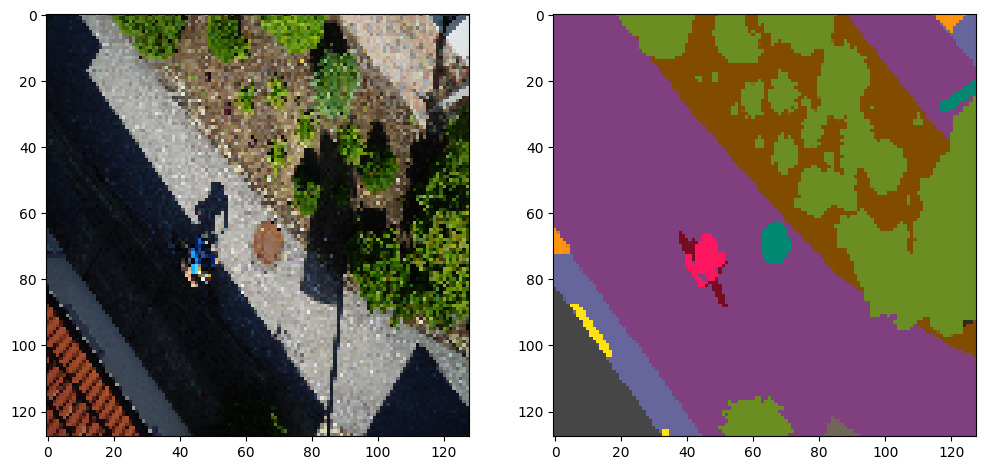

In [ ]:
# Checking if the training data is imported properly.
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(mask_dataset[image_number])
plt.show()

In [ ]:
mask_labels = pd.read_csv("/content/drive/MyDrive/aerial_semantic_segmentation/aerial_dataset/class_dict_seg.csv")
mask_labels


,name,r,g,b
0,unlabeled,0,0,0
1,paved-area,128,64,128
2,dirt,130,76,0
3,grass,0,102,0
4,gravel,112,103,87
5,water,28,42,168
6,rocks,48,41,30
7,pool,0,50,89
8,vegetation,107,142,35
9,roof,70,70,70


In [ ]:
# converting 3 values (RGB) to 1 label values...
def rgb_to_labels(img, mask_labels):
    label_seg = np.zeros(img.shape,dtype=np.uint8)
    for i in range(mask_labels.shape[0]):
        label_seg[np.all(img == list(mask_labels.iloc[i, [1,2,3]]), axis=-1)] = i
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels...
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_labels(mask_dataset[i], mask_labels) # calling rgb to labels for each images...
    labels.append(label)

labels = np.array(labels)
print(labels.shape, labels.size, type(labels))
labels = np.expand_dims(labels, axis=3) # adding channel dimensionality
print(labels.shape, labels.size)


(400, 128, 128) 6553600 <class 'numpy.ndarray'>
(400, 128, 128, 1) 6553600


Unique labels in label dataset are:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]


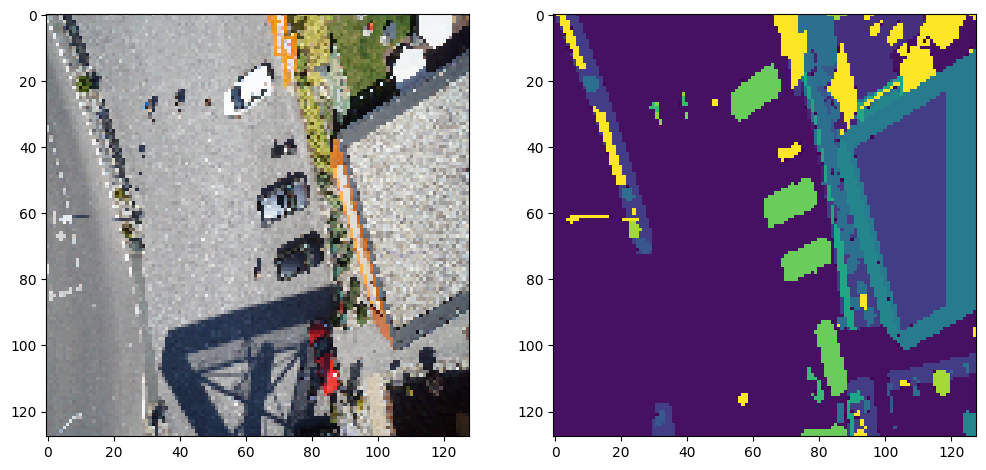

In [ ]:
print("Unique labels in label dataset are: ", np.unique(labels))

#Another Sanity check...
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

In [ ]:
n_classes = len(np.unique(labels)) # 23 classes...
labels_cat = to_categorical(labels, num_classes=n_classes) # one hot encoding the l
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42) # train test split for data...

### Setting the Backbone and Preprocessing

```BACKBONE = 'resnet34' ```
* This line specifies that 'resnet34', a variant of the ResNet model with 34 layers, will be used as the backbone for the U-Net model. In neural networks, a "backbone" refers to a pre-trained network that is used as the base for another task, providing learned features from a large and diverse dataset (like ImageNet).

``` preprocess_input = sm.get_preprocessing(BACKBONE) ```
* This line retrieves the preprocessing function specific to the 'resnet34' model. Different models often require different kinds of input preprocessing (like normalization, scaling, etc.). sm likely refers to a library or module that contains these functions (possibly segmentation_models if you are using that library).

In [ ]:
# using weights from pretained resnet model...
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

### **Preprocessing the data**
* Here, we apply the preprocessing function to the training and testing data.
* This ensires that the input data us in the correct format and range expected by the 'resnet34' backbone. This typically involves normalizing the image data to match the distribution with which the model was originally trained.

In [ ]:
# preprocess input...
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

### **Defining the U-Net Model with ResNet Backbone**
* This function creates a U-Net architecture.U-Net is a popular architecture in image segmentation tasks, particularly known for its effectiveness in medical image segmentation.
* It typically consists of an encoder (downsampling path) and a decoder (upsampling path) with skip connections.
* The BACKBONE parameter specifies that the encoder part of the U-Net should use the 'resnet34' model.
``` encoder_weights='imagenet' ```
* This indicates that the ResNet backbone should be initialized with weights pre-trained on ImageNet, a large dataset of general images. Using pre-trained weights helps in leveraging the features learned by the model on ImageNet, which can improve performance especially when you have limited training data

```classes=n_classes```
* This specifies the number of classes for the segmentation task.

``` activation='softmax' ```
* This is used in the final layer. The softmax activation function is appropriate for multi-class segmentation tasks as it converts the output to a probability distributions over the classes.

In [ ]:
#define model...
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax')

85521592/85521592 [==============================] - 0s 0us/step


In [ ]:
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

In [ ]:


model_resnet_backbone.summary()



Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

* Setting verbose=1 means that you want to see a moderate level of output detail during training. This is typically the most commonly used verbosity level for training models, as it provides useful information without being overly detailed.
* verbose=0: This is a silent mode.
* verbose=2: This setting usually displays one line per epoch but without the progress bar.

In [ ]:


# training the model for 100 epochs with batch size of 16...
history = model_resnet_backbone.fit(X_train_prepr,
          y_train,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr, y_test))



Epoch 1/100
20/20 [==============================] - 35s 176ms/step - loss: 2.5333 - accuracy: 0.3449 - val_loss: 30.2990 - val_accuracy: 0.2242
Epoch 2/100
20/20 [==============================] - 2s 107ms/step - loss: 1.7441 - accuracy: 0.5388 - val_loss: 184.0420 - val_accuracy: 0.3308
Epoch 3/100
20/20 [==============================] - 2s 120ms/step - loss: 1.5574 - accuracy: 0.5670 - val_loss: 29786.9746 - val_accuracy: 0.3741
Epoch 4/100
20/20 [==============================] - 2s 114ms/step - loss: 1.3963 - accuracy: 0.5994 - val_loss: 17722.6836 - val_accuracy: 0.3435
Epoch 5/100
20/20 [==============================] - 2s 109ms/step - loss: 1.2780 - accuracy: 0.6167 - val_loss: 158.8398 - val_accuracy: 0.3003
Epoch 6/100
20/20 [==============================] - 2s 105ms/step - loss: 1.1827 - accuracy: 0.6606 - val_loss: 44.2401 - val_accuracy: 0.3169
Epoch 7/100
20/20 [==============================] - 2s 107ms/step - loss: 1.1440 - accuracy: 0.6671 - val_loss: 122.2120 - val

### **Results**

* The accuracy drops observed at certain points, particularly in the validation accuracy, can be due to several factors:
* Learning Rate: If the learning rate is too high, the model might overshoot the optimal point during optimization.
* Mini-Batch Gradient Descent: If the training uses mini-batches, the model updates weights after seeing only a subset of the data. Some batches might not be representative of the overall data distribution, leading to temporary drops in accuracy.
*

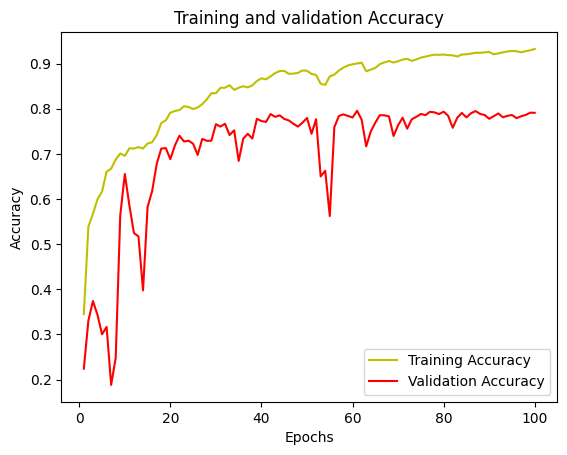

In [ ]:
# plotting train and val accuracy in each epoch...
history = history
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, 'y', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model_resnet_backbone.save('/content/drive/MyDrive/aerial_semantic_segmentation/models/resnet34_backbone.hdf5')

In [ ]:
model_resnet34 = load_model('/content/drive/MyDrive/aerial_semantic_segmentation/models/resnet34_backbone.hdf5')

In [ ]:
y_pred = model_resnet34.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)

3/3 [==============================] - 3s 25ms/step


In [ ]:
rand_image_number = random.randint(0, len(X_test))
rand_image = X_test[rand_image_number]
ground_truth = y_test_argmax[rand_image_number]
rand_image_input = np.expand_dims(rand_image, 0)
prediction = model_resnet34.predict(rand_image_input)
predicted_img = np.argmax(prediction, axis=3)[0,:,:]

1/1 [==============================] - 2s 2s/step


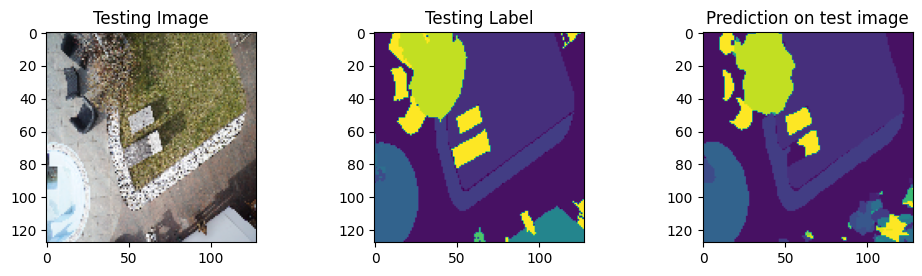

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(rand_image)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

## Trying different backbones on U-Net Architecture.

### ResNet18


In [ ]:
BACKBONE_resnet18 = 'resnet18'
preprocess_input_resnet18 = sm.get_preprocessing(BACKBONE_resnet18)
# preprocess input
X_train_prepr_resnet18 = preprocess_input_resnet18(X_train)
X_test_prepr_resnet18 = preprocess_input_resnet18(X_test)
#define model
model_resnet_backbone_resnet18 = sm.Unet(BACKBONE_resnet18, encoder_weights='imagenet', classes=n_classes, activation='softmax')
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone_resnet18.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model_resnet_backbone_resnet18.summary()

# training the model for 100 epochs with batch size of 16
history_resnet18 = model_resnet_backbone_resnet18.fit(X_train_prepr_resnet18,
          y_train,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr_resnet18, y_test))

44920640/44920640 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d_34 (ZeroPad  (None, None, None, 3)        0         ['bn_data[0][0]']             
 ding2D)                                                                                          
                           

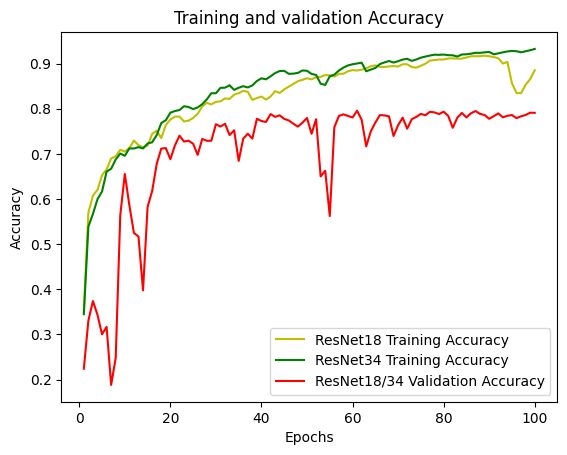

In [ ]:
# plotting train and val accuracy in each epoch...
# history = history_resnet18
accuracy_resnet18 = history_resnet18.history['accuracy']
val_accuracy_resnet18 = history.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_resnet18, 'y', label='ResNet18 Training Accuracy')
plt.plot(epochs, accuracy, 'g', label='ResNet34 Training Accuracy')

plt.plot(epochs, val_accuracy_resnet18, 'r', label='ResNet18/34 Validation Accuracy')
# plt.plot(epochs, val_accuracy, 'b', label='ResNet34 Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### VGG16

In [ ]:
BACKBONE_vgg16 = 'vgg16'
preprocess_input_vgg16 = sm.get_preprocessing(BACKBONE_vgg16)
# preprocess input
X_train_prepr_vgg16 = preprocess_input_vgg16(X_train)
X_test_prepr_vgg16 = preprocess_input_vgg16(X_test)
#define model
model_resnet_backbone_vgg16 = sm.Unet(BACKBONE_vgg16, encoder_weights='imagenet', classes=n_classes, activation='softmax')
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['iou_score']
model_resnet_backbone_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model_resnet_backbone_vgg16.summary()

# training the model for 100 epochs with batch size of 16
history_vgg16 = model_resnet_backbone_resnet18.fit(X_train_prepr_vgg16,
          y_train,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr_vgg16, y_test))

NameError: ignored

In [ ]:
print(history_vgg16.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


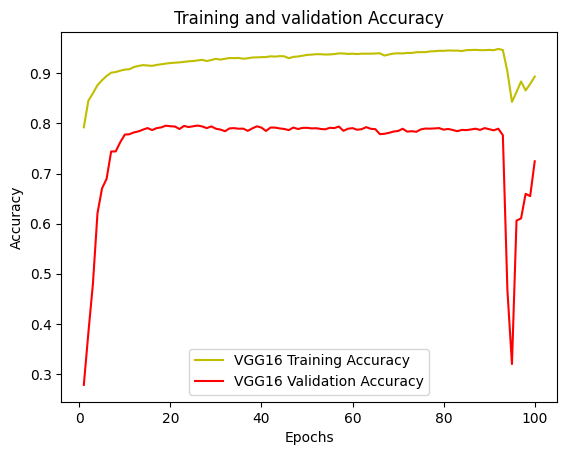

In [ ]:
# plotting train and val accuracy in each epoch...
accuracy_vgg16 = history_vgg16.history['accuracy']
val_accuracy_vgg16 = history_vgg16.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_vgg16, 'y', label='VGG16 Training Accuracy')
# plt.plot(epochs, accuracy, 'g', label='ResNet34 Training Accuracy')

plt.plot(epochs, val_accuracy_vgg16, 'r', label='VGG16 Validation Accuracy')
# plt.plot(epochs, val_accuracy, 'b', label='ResNet34 Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## VGG19

In [ ]:
BACKBONE_vgg19 = 'vgg19'
preprocess_input_vgg19 = sm.get_preprocessing(BACKBONE_vgg19)
# preprocess input
X_train_prepr_vgg19 = preprocess_input_vgg19(X_train)
X_test_prepr_vgg19 = preprocess_input_vgg19(X_test)
#define model
model_resnet_backbone_vgg19 = sm.Unet(BACKBONE_vgg19, encoder_weights='imagenet', classes=n_classes, activation='softmax')
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone_vgg19.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model_resnet_backbone_vgg19.summary()

# training the model for 100 epochs with batch size of 16
history_vgg19 = model_resnet_backbone_vgg19.fit(X_train_prepr_vgg19,
          y_train,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr_vgg19, y_test))

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, None, None, 64)       1792      ['input_3[0][0]']             
                                                                                                  
 block1_conv2 (Conv2D)       (None, None, None, 64)       36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, None, None, 64)       0         ['block1_conv2[0][0]']        
                                                                                            

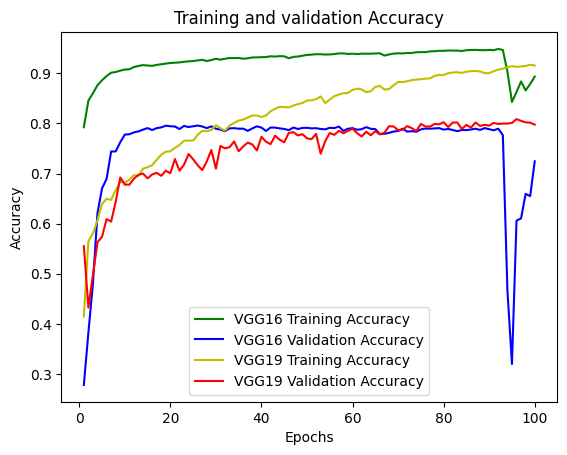

In [ ]:
# plotting train and val accuracy in each epoch...
accuracy_vgg19 = history_vgg19.history['accuracy']
val_accuracy_vgg19 = history_vgg19.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_vgg16, 'g', label='VGG16 Training Accuracy')
plt.plot(epochs, val_accuracy_vgg16, 'b', label='VGG16 Validation Accuracy')

plt.plot(epochs, accuracy_vgg19, 'y', label='VGG19 Training Accuracy')
plt.plot(epochs, val_accuracy_vgg19, 'r', label='VGG19 Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## EfficientNet

In [ ]:
BACKBONE_efficientnetb0 = 'efficientnetb0'
preprocess_input_efficientnetb0 = sm.get_preprocessing(BACKBONE_efficientnetb0)
# preprocess input
X_train_prepr_efficientnetb0 = preprocess_input_efficientnetb0(X_train)
X_test_prepr_efficientnetb0 = preprocess_input_efficientnetb0(X_test)
#define model
model_resnet_backbone_efficientnetb0 = sm.Unet(BACKBONE_efficientnetb0, encoder_weights='imagenet', classes=n_classes, activation='softmax')
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone_efficientnetb0.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model_resnet_backbone_efficientnetb0.summary()

# training the model for 100 epochs with batch size of 16
history_efficientnetb0 = model_resnet_backbone_efficientnetb0.fit(X_train_prepr_efficientnetb0,
          y_train,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr_efficientnetb0, y_test))

16804768/16804768 [==============================] - 0s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 32)       864       ['input_4[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 32)       128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio

In [ ]:
BACKBONE_efficientnetb7 = 'efficientnetb7'
preprocess_input_efficientnetb7 = sm.get_preprocessing(BACKBONE_efficientnetb7)
# preprocess input
X_train_prepr_efficientnetb7 = preprocess_input_efficientnetb7(X_train)
X_test_prepr_efficientnetb7 = preprocess_input_efficientnetb7(X_test)
#define model
model_resnet_backbone_efficientnetb7 = sm.Unet(BACKBONE_efficientnetb7, encoder_weights='imagenet', classes=n_classes, activation='softmax')
# accuracy as metrics, adam optimizer and loss function that needs to be optimized is categorical crossentropy as its a multiclass classification problem...
metrics=['accuracy']
model_resnet_backbone_efficientnetb7.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
model_resnet_backbone_efficientnetb7.summary()

# training the model for 100 epochs with batch size of 16
history_efficientnetb7 = model_resnet_backbone_efficientnetb7.fit(X_train_prepr_efficientnetb7,
          y_train,
          batch_size=16,
          epochs=100,
          verbose=1,
          validation_data=(X_test_prepr_efficientnetb7, y_test))

258434480/258434480 [==============================] - 5s 0us/step
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, None, None, 64)       1728      ['input_5[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, None, None, 64)       256       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activat

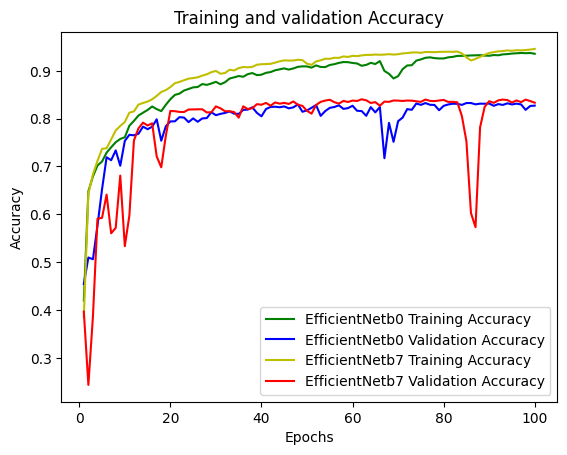

In [ ]:
# plotting train and val accuracy in each epoch...
accuracy_efficientnetb0 = history_efficientnetb0.history['accuracy']
val_accuracy_efficientnetb0 = history_efficientnetb0.history['val_accuracy']
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy_efficientnetb0, 'g', label='EfficientNetb0 Training Accuracy')
plt.plot(epochs, val_accuracy_efficientnetb0, 'b', label='EfficientNetb0 Validation Accuracy')

accuracy_efficientnetb7 = history_efficientnetb7.history['accuracy']
val_accuracy_efficientnetb7 = history_efficientnetb7.history['val_accuracy']
plt.plot(epochs, accuracy_efficientnetb7, 'y', label='EfficientNetb7 Training Accuracy')
plt.plot(epochs, val_accuracy_efficientnetb7, 'r', label='EfficientNetb7 Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

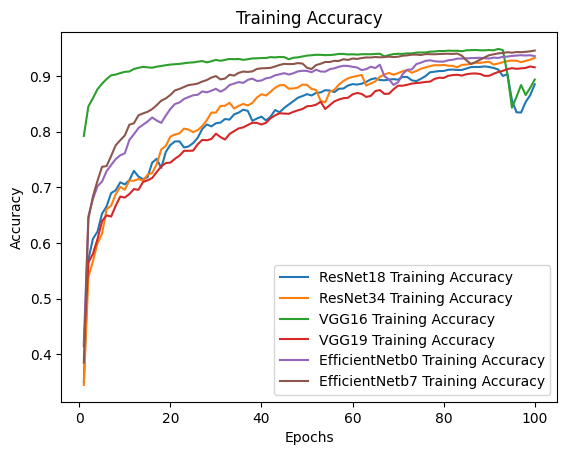

In [ ]:
# plotting train and val accuracy in each epoch...
plt.plot(epochs, accuracy_resnet18, label='ResNet18 Training Accuracy')
plt.plot(epochs, accuracy, label='ResNet34 Training Accuracy')

plt.plot(epochs, accuracy_vgg16, label='VGG16 Training Accuracy')
plt.plot(epochs, accuracy_vgg19,  label='VGG19 Training Accuracy')


plt.plot(epochs, accuracy_efficientnetb0, label='EfficientNetb0 Training Accuracy')

plt.plot(epochs, accuracy_efficientnetb7, label='EfficientNetb7 Training Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

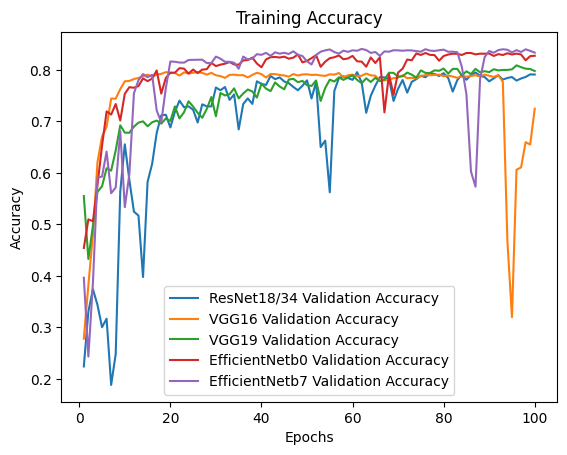

In [ ]:
plt.plot(epochs, val_accuracy_resnet18, label='ResNet18/34 Validation Accuracy')
plt.plot(epochs, val_accuracy_vgg16, label='VGG16 Validation Accuracy')
plt.plot(epochs, val_accuracy_vgg19, label='VGG19 Validation Accuracy')
plt.plot(epochs, val_accuracy_efficientnetb0, label='EfficientNetb0 Validation Accuracy')
plt.plot(epochs, val_accuracy_efficientnetb7, label='EfficientNetb7 Validation Accuracy')
plt.title('Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Intersection over Union metric
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.IoU(num_classes=2)])

NameError: ignored